# Audio Data Augmentation

by @ste & @zachcaceres

In [1]:
# %%bash
# pip install pydub --user
# sudo apt-get install ffmpeg
# sudo apt-get install sox libsox-dev libsox-fmt-all
# git clone https://github.com/pytorch/audio.git torchaudio
# cd torchaudio
# python setup.py install
# %%

In [2]:
#Export
import glob
import matplotlib.pyplot as plt
from fastai.text import * 
from fastai.vision import *
from pathlib import Path
import pandas as pd
from pydub import AudioSegment
import torch
import librosa
import torchaudio
from IPython.display import Audio
from torchaudio import transforms

## Sample Data: Timit

In [3]:
Path.home()

PosixPath('/home/ste')

In [4]:
# Standard path notation for fast.ai
# The files willbe saved on $HOME/.fastai/data/timit/
path = Path(Path.home()/'.fastai/data/timit')
if path.exists: print(f'Working directory: {path}')
else: print('Missing data folder')

Working directory: /home/ste/.fastai/data/timit


In [5]:
sig,sr = torchaudio.load(str(path/'TRAIN/DR1/MDPK0/SA1.WAV'))
display(Audio(data=sig, rate=sr))

We're using **(sig,sr)** for all our tests.

## Setup

In [6]:
# Export
def show_in_out(s, r):
    """Helper to plot input and output signal in different colors"""
    ln = min(s.shape[1], r.shape[1])
    if s is not None: plt.plot(s[0,:ln], 'g')
    if r is not None: plt.plot(r[0,:ln], 'r')

In [7]:
# Export
def tfm_tester(testSignal, testSr, tfm, **kwargs):
    tfms = listify(tfm)
    ret = testSignal
    for t in tfms:
        ret = t(ret, **kwargs)
    display(Audio(data=testSignal, rate=testSr))
    display(Audio(data=ret, rate=testSr))
    show_in_out(testSignal, ret)

# Augmentation Functions

## White Noise

In [8]:
#Export
def tfm_add_white_noise(signal, noise_scl=0.005, **kwargs):
    noise = torch.randn(signal.shape[1]) * noise_scl
    return signal + noise

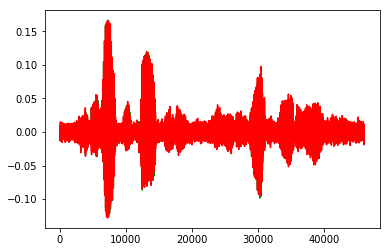

In [9]:
tfm_tester(sig, sr, tfm_add_white_noise, sr=sr)

## Volume Change

In [10]:
#Export
def tfm_modulate_volume(signal, lower_gain=.1, upper_gain=1.2, **kwargs):
    modulation = random.uniform(lower_gain, upper_gain)
    return signal * modulation

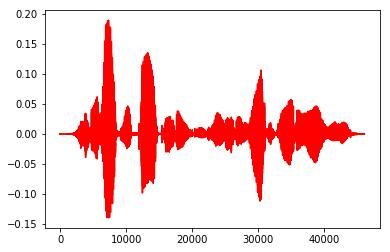

In [11]:
tfm_tester(sig, sr, tfm_modulate_volume)

## Random Cutout

In [12]:
#Export
def tfm_random_cutout(signal, pct_to_cut=.15, **kwargs):
    """Randomly replaces `pct_to_cut` of signal with silence. Similar to grainy radio."""
    copy = signal.clone()
    sig_len = sig.shape[1]
    sigs_to_cut = int(sig_len * pct_to_cut)
    for i in range(0, sigs_to_cut):
        cut_idx = random.randint(0, sig_len - 1)
        copy[0][cut_idx] = 0
    return copy

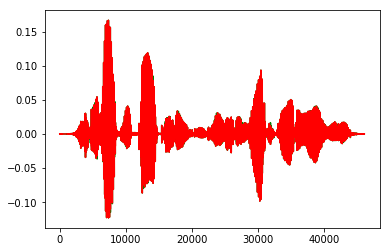

In [13]:
tfm_tester(sig, sr, tfm_random_cutout)

## Pad with Silence

In [14]:
#Export
def tfm_pad_with_silence(signal, pct_to_pad=.15, min_to_pad=None, max_to_pad=None, **kwargs):
    """Adds silence to beginning or end of signal, simulating microphone cut at start of end of audio."""
    if max_to_pad is None: max_to_pad = int(signal.shape[1] * 0.15)
    if min_to_pad is None: min_to_pad = -max_to_pad
    pad = random.randint(min_to_pad, max_to_pad)
    copy = signal.clone()
    if pad >= 0: copy[:,0:pad] = 0
    else: copy[:,pad:] = 0
    return copy

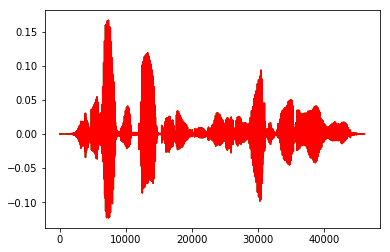

In [15]:
tfm_tester(sig, sr, tfm_pad_with_silence)

## Pitch Warp

In [16]:
#Export
def tfm_pitch_warp(signal, sr=None, shift_by_pitch=None, bins_per_octave=12, **kwargs):
    if shift_by_pitch is None: shift_by_pitch = random.uniform(-3, 3)
    return torch.tensor(librosa.effects.pitch_shift(np.array(signal[0]), sr, shift_by_pitch, bins_per_octave=12))[None,:]

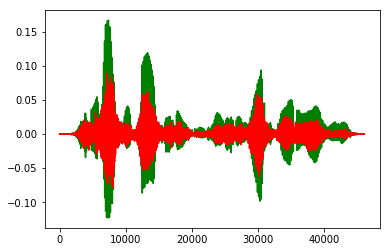

In [17]:
tfm_tester(sig, sr, tfm_pitch_warp,sr=sr)

## Lossy Downsample and Upsample

In [18]:
#Export
def tfm_down_and_up(signal, sr, sr_divisor=2, **kwargs):
    copy = np.array(signal.clone())
    down = librosa.audio.resample(copy, sr, sr/sr_divisor)
    return torch.tensor(librosa.audio.resample(down, sr/sr_divisor, sr))

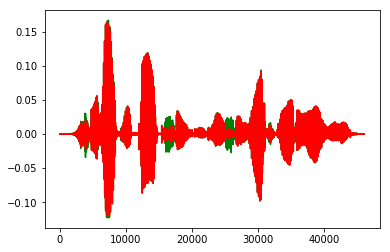

In [19]:
tfm_tester(sig, sr, tfm_down_and_up, sr=sr)

## Signal Mixup

In [20]:
#Export
def tfm_signal_mixup(signal, **kwargs):
    pass

## Combined Augmentations

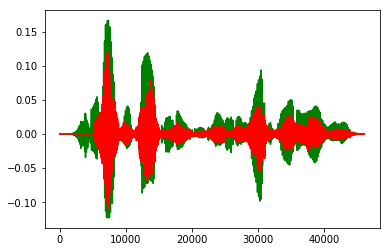

In [21]:
tfm_tester(sig, sr, [tfm_down_and_up, tfm_pitch_warp, tfm_pad_with_silence], sr=sr)

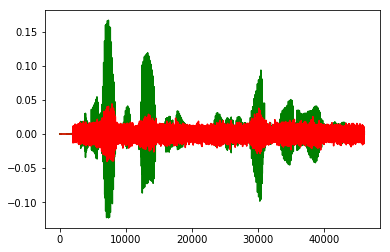

In [22]:
tfm_tester(sig, sr, [tfm_modulate_volume, tfm_pitch_warp, tfm_add_white_noise, tfm_pad_with_silence], sr=sr)

In [23]:
# Other stuff to possibly explore
# AudioSegment(…).overlay()
# AudioSegment(…).apply_gain(gain)
# AudioSegment(…).invert_phase()
# AudioSegment(…).set_sample_width()

# Export

In [24]:
!python notebook2script.py DataAugmentation.ipynb

Converted DataAugmentation.ipynb to nb_DataAugmentation.py


In [ ]:
sig.sh